In [1]:
import sys

sys.path.append("..")

In [ ]:
from pathlib import Path

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.model_manager import MLPManager
from src.loader import parse_out_data, parse_con_parameter
from src.preprocess import fill_nan_with_interp

In [ ]:
model_path = (
    Path("C:\\dev\\science\\xray_reflection\\XRRmaker\\models") / "mlp_model.pth"
)
data_path = Path("C:\\dev\\science\\xray_reflection\\data\\simulation_data")

X_data = []
y_data = []
for num in tqdm(range(1, 10001), desc="Load"):
    out_file = data_path / f"d{num:05}" / "1.out"
    con_file = data_path / f"d{num:05}" / "1.con"
    data = parse_out_data(out_file)
    x = data[["XOBS", "YCALC"]].values
    x = fill_nan_with_interp(x)
    X_data.append(x)
    y = np.asarray(parse_con_parameter(con_file))[
        [4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    ]
    y_data.append(y)

X_data = np.stack(X_data, axis=0)
y_data = np.stack(y_data, axis=0)

Load: 100%|██████████| 10000/10000 [00:14<00:00, 703.22it/s]


In [5]:
# 테스트 데이터셋 비율 설정
test_size = 0.2

# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=test_size, random_state=42, shuffle=True
)

# 나누어진 데이터셋 형상 확인
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (8000, 314, 2), y_train shape: (8000, 15)
X_test shape: (2000, 314, 2), y_test shape: (2000, 15)


Epoch 1/5 - Train Loss: 12094.8799 - Val Loss: 50626.7939
Epoch 2/5 - Train Loss: 5994.1267 - Val Loss: 3012409.6600
Epoch 3/5 - Train Loss: 5532.6660 - Val Loss: 12780.3324
Epoch 4/5 - Train Loss: 5485.5073 - Val Loss: 5937.8395
Epoch 5/5 - Train Loss: 5460.9874 - Val Loss: 5787.9304
Model saved to C:\dev\science\xray_reflection\XRRmaker\models\xrrmlp_model.pth


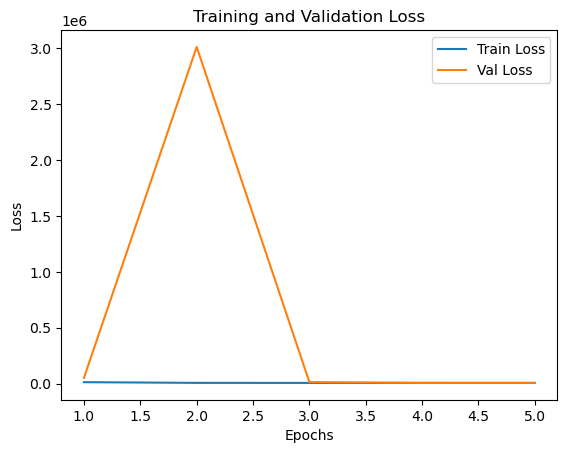

In [6]:
input_dim: int = X_data.shape[1] * X_data.shape[2]
output_dim: int = y_data.shape[1]
manager = MLPManager(input_dim=input_dim, output_dim=output_dim, learning_rate=1e-3)

history = manager.train(
    X_data=X_data,
    y_data=y_data,
    model_path=model_path,
    epochs=5,
    batch_size=64,
    val_ratio=0.1,
    print_every=1,
)

epochs = range(1, len(history["train_loss"]) + 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [7]:
predictions = manager.predict(X_test, model_path=model_path)

idxs = [i + 1 for i in [4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]
print("Predictions Shape:", predictions.shape)

Predictions Shape: (2000, 15)


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 모델 평가
# 평균 제곱 오차 (MSE) 계산
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# 평균 절대 오차 (MAE) 계산
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

output_dim_indices = [4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
for i, idx in enumerate(output_dim_indices):
    mse_single = mean_squared_error(y_test[:, i], predictions[:, i])
    mae_single = mean_absolute_error(y_test[:, i], predictions[:, i])
    print(f"Output Dim {idx} - MSE: {mse_single:.4f}, MAE: {mae_single:.4f}")

Mean Squared Error (MSE): 5848.1583
Mean Absolute Error (MAE): 42.3054
Output Dim 4 - MSE: 1.1389, MAE: 0.8779
Output Dim 5 - MSE: 235.9021, MAE: 13.1653
Output Dim 6 - MSE: 649.8621, MAE: 19.7830
Output Dim 8 - MSE: 5.3941, MAE: 1.8955
Output Dim 9 - MSE: 5818.4740, MAE: 63.1531
Output Dim 10 - MSE: 27.6907, MAE: 4.3318
Output Dim 11 - MSE: 21690.4110, MAE: 126.2728
Output Dim 12 - MSE: 12.9303, MAE: 2.9331
Output Dim 13 - MSE: 6341.8739, MAE: 65.1735
Output Dim 14 - MSE: 2.9594, MAE: 1.4324
Output Dim 15 - MSE: 23187.5979, MAE: 131.1512
Output Dim 16 - MSE: 4.3870, MAE: 1.7335
Output Dim 17 - MSE: 6501.9412, MAE: 67.3141
Output Dim 18 - MSE: 29.1219, MAE: 4.4052
Output Dim 19 - MSE: 23212.6908, MAE: 130.9580
